In [1]:
import cobra
import GEMS
import pandas as pd
import numpy as np
import os


import pickle
from etcpy import etc
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt

In [2]:
data = GEMS.load_exp_data('../data/ExpGrowth.csv')
path = '../'
params = pd.read_csv(os.path.join(path,'data/model_enzyme_params_new.csv'),index_col=0)
df = etc.calculate_thermal_params(params)

dfae_batch = data[0].set_index('Ts').rename_axis(None)
params

,Topt,Topt_std,Length,Tm,Tm_std,T90,dCpt,dCpt_std,topt_source
P77467,306.15,10,262,328.717325,7.588735,NaN,-4000,1000,predicted
P76077,311.15,10,309,328.717325,7.588735,NaN,-4000,1000,predicted
P76078,310.15,10,95,328.717325,7.588735,NaN,-4000,1000,BullShit
P76079,309.15,10,248,328.717325,7.588735,NaN,-4000,1000,predicted
P76081,310.15,10,356,328.717325,7.588735,NaN,-4000,1000,BullShit
...,...,...,...,...,...,...,...,...,...
P0AG80,313.15,10,438,329.166303,4.070000,330.45,-4000,1000,predicted
P77718,307.15,10,482,319.125751,4.070000,320.15,-4000,1000,predicted
P0A6D5,308.15,10,288,328.762604,7.710000,NaN,-4000,1000,predicted
standard,308.15,10,272,328.762604,7.710000,NaN,-4000,1000,BullShit


In [9]:
params = etc.sample_data_uncertainty_with_constraint_increasing_topt(params)
    # thermalParams: a dictionary with ids like uniprotid_Topt 
params

,Topt,Topt_std,Length,Tm,Tm_std,T90,dCpt,dCpt_std,topt_source
P77467,310.15,10,262,328.717325,7.588735,NaN,-4596.512887,1000,predicted
P76077,315.15,10,309,328.717325,7.588735,NaN,-4748.710400,1000,predicted
P76078,316.15,10,95,328.717325,7.588735,NaN,-3689.364646,1000,BullShit
P76079,313.15,10,248,328.717325,7.588735,NaN,-4488.865046,1000,predicted
P76081,316.15,10,356,328.717325,7.588735,NaN,-4751.798630,1000,BullShit
...,...,...,...,...,...,...,...,...,...
P0AG80,317.15,10,438,329.166303,4.070000,330.45,-1648.030181,1000,predicted
P77718,311.15,10,482,319.125751,4.070000,320.15,-3517.435828,1000,predicted
P0A6D5,312.15,10,288,328.762604,7.710000,NaN,-4552.974638,1000,predicted
standard,314.15,10,272,328.762604,7.710000,NaN,-5198.768072,1000,BullShit


In [4]:
df = etc.calculate_thermal_params(params)
df

,dHTH,dSTS,dCpu,Topt,dCpt
P77467,1.191000e+06,3924.740000,13826.625515,308.15,-5119.384654
P76077,1.379000e+06,4548.430000,16200.250055,313.15,-5445.900676
P76078,5.230000e+05,1708.650000,5392.683003,313.15,-3382.252470
P76079,1.135000e+06,3738.960000,13119.588419,311.15,-4676.679015
P76081,1.567000e+06,5172.120000,18573.874594,313.15,-3900.539076
...,...,...,...,...,...
P0AG80,3.502960e+06,11626.117181,44745.700617,315.15,-3005.831638
P77718,4.452503e+06,14795.696475,48833.651622,309.15,-3323.297158
P0A6D5,1.295000e+06,4269.760000,15151.543397,310.15,-2249.782247
standard,1.231000e+06,4057.440000,14342.966810,311.15,-3722.527252


In [5]:
def aerobic(params):
    # thermalParams: a dictionary with ids like uniprotid_Topt 
    df = etc.calculate_thermal_params(params)
    #mae = pickle.load(open(os.path.join(path,'models/aerobic.pkl'),'rb'))
    mae = cobra.io.load_matlab_model('../models/ecModel.mat')
    
    #mae = GEMS.addNGAMreaction(mae)
    mae.reactions.EX_glc__D_e.lower_bound = -100
    mae.reactions.BIOMASS_Ec_iJO1366_core_53p95M.upper_bound = 50
    
    try: 
        rae, gae, oae = etc.simulate_growth(mae,dfae_batch.index+273.15,df=df,sigma=0.5)
    except: 
        rae = np.zeros(dfae_batch.shape[0])
        model = None
    
    rae = [0 if x is None else x for x in rae]
    rae = [0 if x<1e-3 else x for x in rae]
    #print(rae)
    #rexp = GEMS.aerobic_exp_data()['data']
    print(rae)
    print(abs(rae - dfae_batch['r'].values))
    #print('r2_batch:',r2_score(rexp,rae))
    #print('MSE_ae',MSE(rexp,rae))
    return {'growth':np.array(rae), 'glucose':np.array(gae), 'oxygen': np.array(oae)}

In [10]:
rae = aerobic(params)

NGAM is: 3.23
Growth at  20.153299075508016 is:  0.0
NGAM is: 3.23
Growth at  23.00151111308503 is:  0.0064894362315117155
NGAM is: 3.666948749964016
Growth at  26.331896319367047 is:  0.01897324187997146
NGAM is: 4.228097946953468
Growth at  28.251819864188008 is:  0.03332813776761483
NGAM is: 4.675583853845237
Growth at  29.99421176442104 is:  0.053721420015357624
NGAM is: 5.047267123847456
Growth at  31.62212188446705 is:  0.08156310209630746
NGAM is: 5.44939156263788
Growth at  33.61728633658504 is:  0.13116582113423234
NGAM is: 5.950125048399887
Growth at  36.55299482796005 is:  0.24568236655044648
NGAM is: 6.237403245621997
Growth at  38.54155004207803 is:  0.3585865062201083
NGAM is: 6.449817187489966
Growth at  40.20094365636703 is:  0.47792666972524966
NGAM is: 6.681009354243395
Growth at  42.23876395989504 is:  0.4222513419479108
NGAM is: 6.9000236503978725
Growth at  44.453491097574044 is:  0.3589630197703501
NGAM is: 6.974987953458825
Growth at  45.28989924561603 is:  0.335

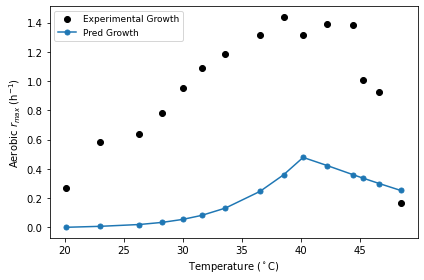

In [11]:
plt.figure()
plt.scatter(dfae_batch.index,dfae_batch['r'].values,label='Experimental Growth',color='k')
plt.plot(dfae_batch.index,rae['growth'],markersize=5,marker='o',label='Pred Growth')
#plt.plot(dfae_batch.index,rae['glucose'],markersize=5,marker='o',label='Glucose')
#plt.plot(dfae_batch.index,rae['oxygen'],markersize=5,marker='o',label='Oxygen')
plt.xlabel('Temperature ($^\circ$C)')
#plt.ylabel('Specific growth rate (h$^{-1}$)')
plt.ylabel('Aerobic $r_{max}$ (h$^{-1}$)')

plt.legend(fontsize=9,loc='upper left')
plt.tight_layout()
#plt.savefig('../results/presentation22.png')
plt.show()

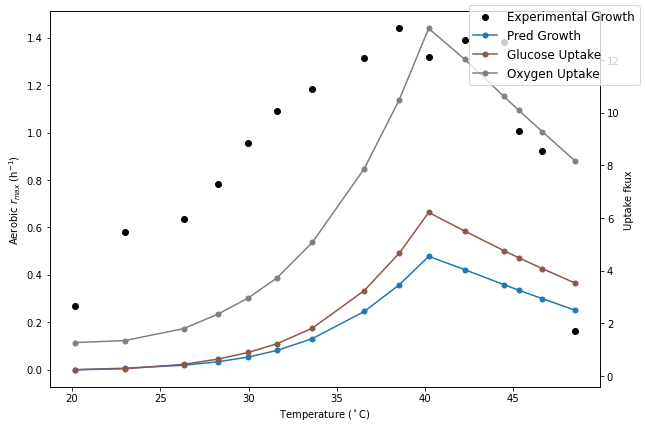

In [12]:
fig, ax1 = plt.subplots(figsize=(9, 6))
ax2 = ax1.twinx()

ax1.scatter(dfae_batch.index,dfae_batch['r'].values,label='Experimental Growth',color='k')
ax1.plot(dfae_batch.index,rae['growth'],markersize=5,marker='o',label='Pred Growth')

ax2.plot(dfae_batch.index,rae['glucose'],markersize=5,marker='o',label='Glucose Uptake', color='tab:brown')
ax2.plot(dfae_batch.index,rae['oxygen'],markersize=5,marker='o',label='Oxygen Uptake', color='tab:gray')

ax1.set_xlabel("Temperature ($^\circ$C)")
ax1.set_ylabel("Aerobic $r_{max}$ (h$^{-1}$)")

ax2.set_ylabel("Uptake fkux")

fig.legend(fontsize=12)
fig.tight_layout()

#fig.savefig('../results/ALlinOne22.png')